# Transfer Learning using Yammet [link](https://www.tensorflow.org/tutorials/audio/transfer_learning_audio)

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

# Set the seed value for experiment reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print('GPU: ','available' if tf.config.list_physical_devices('GPU') else 'not avaiable') 

2023-02-23 04:14:40.400883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 04:14:41.437757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 04:14:41.438325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 04:14:41.438345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

GPU:  not avaiable


2023-02-23 04:14:42.494625: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-23 04:14:42.494664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 8cb5a79a356d
2023-02-23 04:14:42.494677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 8cb5a79a356d
2023-02-23 04:14:42.494768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2023-02-23 04:14:42.494798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-02-23 04:14:42.494809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.86.1


In [2]:
os.chdir('8-yamet-audio-recongniton-dataset')

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2023-02-23 04:14:45.045648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# loading ESC-50 dataset with 50 class and 40 exmple each
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [4]:
# reading the data
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
cat = pd_data[['category', 'target']]
cat = cat.drop_duplicates(subset=['target'])
label_names = cat.sort_values(by=['target'])['category']
label_names = list(label_names)
len(label_names)
label_names[36]

'vacuum_cleaner'

In [6]:
# classifying only cats and dogs

my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)


,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


In [13]:
# loading the data

main_ds = tf.data.Dataset.from_tensor_slices((filtered_pd['filename'], filtered_pd['target'], filtered_pd['fold']))
main_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
#getting audio files
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [17]:
# applying yamet embedding 
# it generate embedding every (window size) so for a single input it will produce n x 1024

# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
              tf.repeat(label, num_embeddings),
              tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
# spliting in train and test
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


In [34]:
embed, lab = next(iter(train_ds.take(1)))
embed.shape

TensorShape([32, 1024])

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1024), dtype=tf.float32),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(len(my_classes))
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3, # weight for 3 ecpochs
                                            restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data = val_ds,
    callbacks=callback,
    verbose =2)

Epoch 1/20
15/15 - 1s - loss: 0.6419 - accuracy: 0.8396 - val_loss: 0.2528 - val_accuracy: 0.9062 - 1s/epoch - 89ms/step
Epoch 2/20
15/15 - 0s - loss: 0.4266 - accuracy: 0.8708 - val_loss: 0.2719 - val_accuracy: 0.9187 - 111ms/epoch - 7ms/step
Epoch 3/20
15/15 - 0s - loss: 0.4291 - accuracy: 0.8833 - val_loss: 0.6238 - val_accuracy: 0.8750 - 120ms/epoch - 8ms/step
Epoch 4/20
15/15 - 0s - loss: 0.4934 - accuracy: 0.9042 - val_loss: 0.2087 - val_accuracy: 0.9125 - 111ms/epoch - 7ms/step
Epoch 5/20
15/15 - 0s - loss: 0.4327 - accuracy: 0.9208 - val_loss: 0.2230 - val_accuracy: 0.9187 - 121ms/epoch - 8ms/step


In [39]:
# test the model 
loss, accuracy = model.evaluate(test_ds, verbose=2)

5/5 - 0s - loss: 0.3562 - accuracy: 0.9000 - 175ms/epoch - 35ms/step


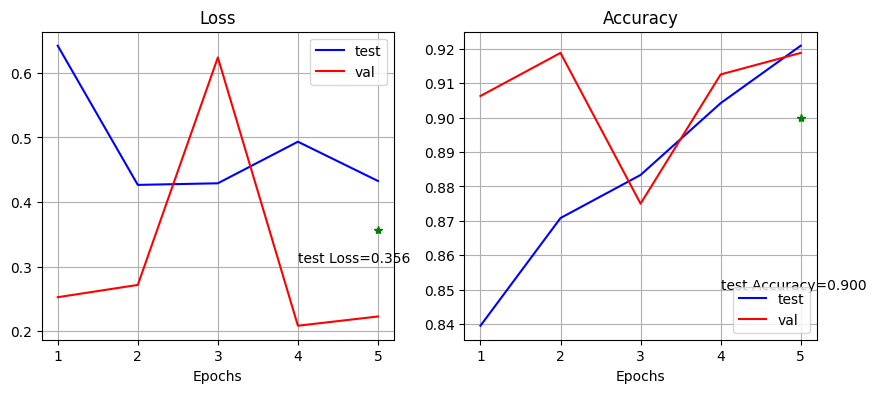

In [40]:
def plot_test_val(ax, title, test, val, test_point):
    x = np.arange(1, len(test) +1, 1)
    ax.plot(x, test, label='test', color='b')
    ax.plot(x, val, label='val', color='r')
    ax.plot([len(test)], [test_point], 'g*')
    ax.annotate(f"test {title}={test_point:.3f}", xy=(len(test), test_point), xytext=(len(test)-1, test_point-.05))
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.set_title(title)
    ax.grid()
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_test_val(ax1, 'Loss', history.history['loss'], history.history['val_loss'], loss)
plot_test_val(ax2, 'Accuracy', history.history['accuracy'], history.history['val_accuracy'], accuracy)

plt.show()


In [44]:
# constructing average layer
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)
tf.keras.utils.plot_model(serving_model)


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
reloaded_model = tf.saved_model.load(saved_model_path)
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')


NameError: name 'testing_wav_data' is not defined